In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [4]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = './images/real_photos/'
TRAIN_LABELS_PATH = './images/labels/'
TEST_PATH = './V3/Test/Test_labels'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [5]:
train_ids = []
for root, dirs, files in os.walk(TRAIN_PATH, topdown=False):
    for name in files:
        if(name.lower().endswith(('.jpg', '.png'))):
            train_ids.append(name)
print(train_ids[4])
# test_ids = []
# for root, dirs, files in os.walk(TEST_PATH, topdown=False):
#     for name in files:
#         if(name.lower().endswith('.bmp')):
#             # [21:] removes the prefix
#             test_ids.append(os.path.join(root, name)[21:])

11655662394_ff085aba45_o_scaled.jpg


In [6]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    # resize training image and add into list as np array
    img = imread(TRAIN_PATH+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    # make all bg pixels in mask image red
    mask_id = id_[:-3] + "png"
    img = imread(TRAIN_LABELS_PATH+mask_id)
    size = img.shape
    redColor = [0, 0, 0]
    for x in range(size[0]):
        for y in range(size[1]):
            pixel = img[x, y]
            if(pixel[0] == redColor[0] and pixel[1] == redColor[1] and pixel[2] == redColor[2]):
                img[x, y] = 0
    # make mask image boolean matrix (0 for bg and 1 for mask)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.clip(img, 0, 1)
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            pixel = img[x, y]
            if (any(z > 0 for z in pixel)):
                Y_train[n][x][y] = 1
            else:
                Y_train[n][x][y] = 0

Getting and resizing train images and masks ... 


In [7]:
# Split train and valid
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Mask')

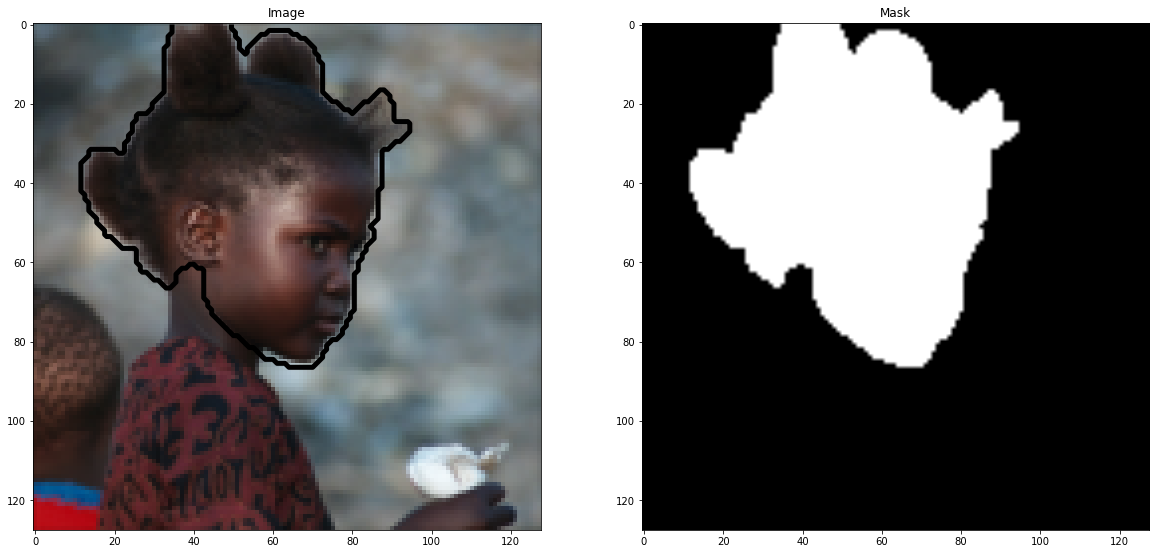

In [26]:
ix = random.randint(0, len(X_train))
has_mask = Y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix])
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(Y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(Y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [10]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread('./V3/Test/Test_RGB/'+id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

NameError: name 'test_ids' is not defined

In [5]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [6]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [30]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('face-segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
# earlystopper = EarlyStopping(patience=3, verbose=1)
# checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, batch_size=32, epochs=10, callbacks=callbacks, validation_data=(X_valid, Y_valid))

Train on 2250 samples, validate on 250 samples
Epoch 1/10
2250/2250 [==============================] - 238s 106ms/step - loss: 0.4939 - accuracy: 0.7572 - val_loss: 0.9183 - val_accuracy: 0.7001

Epoch 00001: val_loss improved from inf to 0.91833, saving model to face-segmentation.h5
Epoch 2/10
2250/2250 [==============================] - 214s 95ms/step - loss: 0.4108 - accuracy: 0.8104 - val_loss: 0.7108 - val_accuracy: 0.6912

Epoch 00002: val_loss improved from 0.91833 to 0.71082, saving model to face-segmentation.h5
Epoch 3/10
2250/2250 [==============================] - 207s 92ms/step - loss: 0.3848 - accuracy: 0.8245 - val_loss: 0.5739 - val_accuracy: 0.7398

Epoch 00003: val_loss improved from 0.71082 to 0.57386, saving model to face-segmentation.h5
Epoch 4/10
2250/2250 [==============================] - 210s 93ms/step - loss: 0.3616 - accuracy: 0.8371 - val_loss: 0.6213 - val_accuracy: 0.7317

Epoch 00004: val_loss did not improve from 0.57386
Epoch 5/10
2250/2250 [============

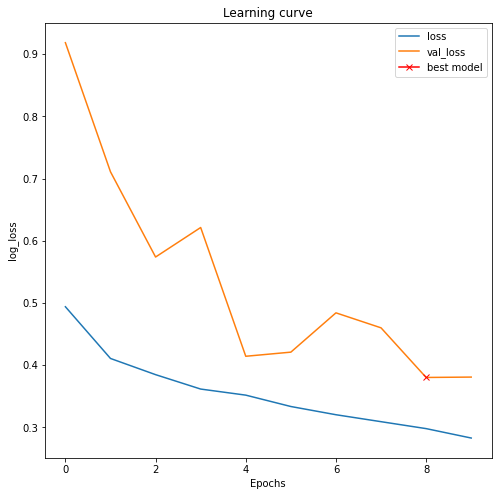

In [31]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Predictions with Trained Weights

In [5]:
model.load_weights('face-segmentation.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, Y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
# preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                        (sizes_test[i][0], sizes_test[i][1]), 
#                                        mode='constant', preserve_range=True))
# imshow(preds_test_upsampled[4])

NameError: name 'X_valid' is not defined

In [33]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('img')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('ground truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Predicted binary');

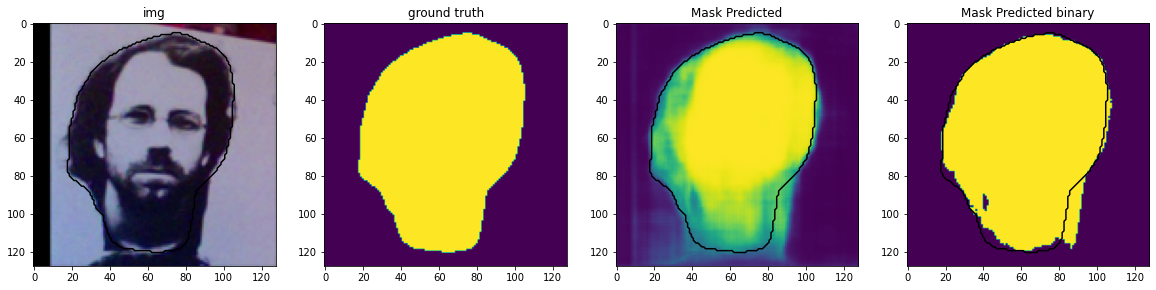

In [39]:
ix = random.randint(0, len(X_train))
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=ix)

In [70]:
# ix = random.randint(0, len(X_test))

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 10))

# ax1.imshow(X_test[ix])
# ax1.set_title('Image')

# ax2.imshow(preds_test_t[ix].squeeze(), vmin=0, vmax=1)
# ax2.set_title('Predicted Mask')

# img_resize = resize(X_test[ix], (sizes_test[ix][0], sizes_test[ix][1]))
# ax3.imshow(img_resize)
# ax3.set_title('Picture Scaled to Original Size')

# ax4.imshow(preds_test_upsampled[ix], vmin=0, vmax=1)
# ax4.set_title('Mask Scaled to Original Size')

## Single Prediction from 'images' Directory

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Mask')

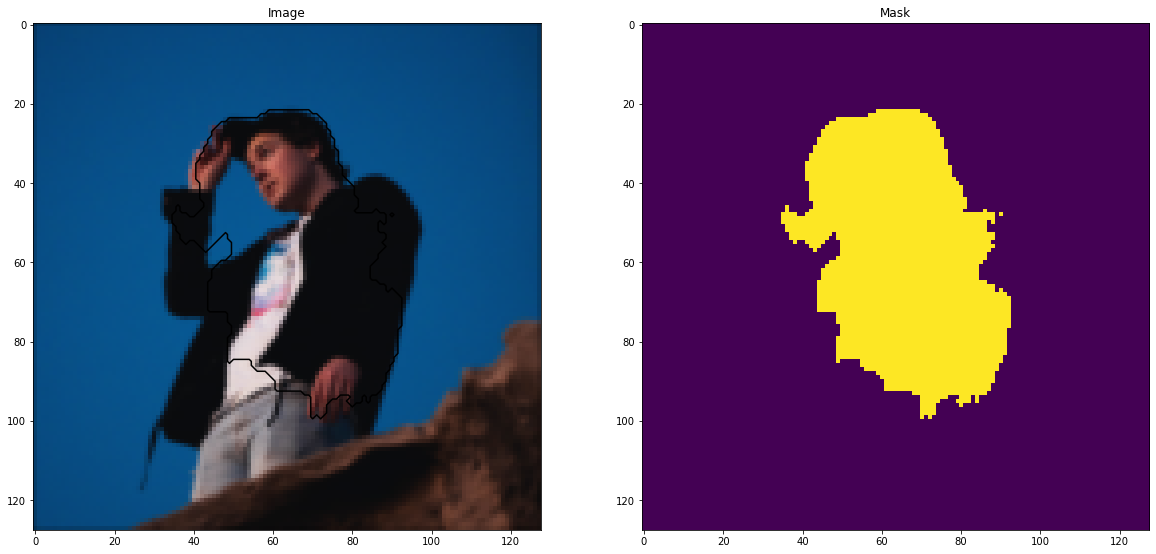

In [7]:
model.load_weights('face-segmentation.h5')

from keras.preprocessing.image import array_to_img, img_to_array, load_img
X = np.zeros((1, 128, 128, 3), dtype=np.float32)

# insert img path here to test single image
img = imread('./images/DSC02369-2.jpg')

x_img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
X[0] = x_img
preds_test2 = model.predict(X, verbose=1)
preds_test2 = (preds_test2 > 0.7).astype(np.uint8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(X[0].astype('uint8'))
ax1.contour(preds_test2[0].squeeze(), colors='k', levels=[0.5])
ax1.set_title('Image')

ax2.imshow(preds_test2[0].squeeze(), vmin=0, vmax=1)
ax2.set_title('Mask')